In [5]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [109]:
import os
import shutil
from datetime import datetime
import pandas as pd

# Setup
sales_dir = "Pharma_Sales_Dataset"
archive_dir = "Archives/Archived Sales Data"
date_stamp = datetime.today().strftime('%Y-%m-%d')

# Files to load and archive
sales_files = {
    "salesdaily": "salesdaily.csv",
    "saleshourly": "saleshourly.csv",
    "salesweekly": "salesweekly.csv",
    "salesmonthly": "salesmonthly.csv"
}

sales_data = {}

for label, filename in sales_files.items():
    src = os.path.join(sales_dir, filename)
    dst = os.path.join(archive_dir, f"{label}_archive_{date_stamp}.csv")

    # Load into pandas and store in dictionary
    try:
        df = pd.read_csv(src)
        sales_data[label] = df
        shutil.copy(src, dst)
        print(f"{label} loaded and archived → {dst}")
    except Exception as e:
        print(f"❌ Failed for {label}: {e}")

forecast_files = [
    "Forecasting Data.xlsx",
    "best_model_summary_metrics.csv",
    "seasonality_strength.csv"
]

forecast_dir = "Forecasts"
metrics_dir = os.path.join("Forecasts", "Metrics")
forecast_archive_dir = os.path.join("Archives", "Archived Forecasts")
metrics_archive_dir = os.path.join("Archives", "Archived Forecasts", "Archived Metrics")

# Archive forecast outputs
for f in forecast_files:
    src = os.path.join(forecast_dir, f)
    dst = os.path.join(forecast_archive_dir, f.replace(".csv", f"_archive_{date_stamp}.csv") if f.endswith(".csv") else f.replace(".xlsx", f"_archive_{date_stamp}.xlsx"))
    try:
        shutil.copy(src, dst)
        print(f"Archived forecast: {dst}")
    except Exception as e:
        print(f"❌ Forecast archive failed for {f}: {e}")


salesdaily loaded and archived → Archives/Archived Sales Data\salesdaily_archive_2025-04-29.csv
saleshourly loaded and archived → Archives/Archived Sales Data\saleshourly_archive_2025-04-29.csv
salesweekly loaded and archived → Archives/Archived Sales Data\salesweekly_archive_2025-04-29.csv
salesmonthly loaded and archived → Archives/Archived Sales Data\salesmonthly_archive_2025-04-29.csv
Archived forecast: Archives\Archived Forecasts\Forecasting Data_archive_2025-04-29.xlsx
Archived forecast: Archives\Archived Forecasts\best_model_summary_metrics_archive_2025-04-29.csv
Archived forecast: Archives\Archived Forecasts\seasonality_strength_archive_2025-04-29.csv


In [112]:
import pandas as pd
import os

# Paths
sales_dir = "Pharma_Sales_Dataset"
output_file = os.path.join(sales_dir, "Sales_Combined.xlsx")

# Load only daily, weekly, monthly data

df_hourly = pd.read_csv(os.path.join(sales_dir, "saleshourly.csv"))
df_daily = pd.read_csv(os.path.join(sales_dir, "salesdaily.csv"))
df_weekly = pd.read_csv(os.path.join(sales_dir, "salesweekly.csv"))
df_monthly = pd.read_csv(os.path.join(sales_dir, "salesmonthly.csv"))

# Write to Excel with correct sheet order and structure
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    pd.DataFrame().to_excel(writer, sheet_name='saleshourly', index=False)  # empty or stub
    df_hourly.to_excel(writer, sheet_name='saleshourly', index=False)
    df_daily.to_excel(writer, sheet_name='salesdaily', index=False)
    df_weekly.to_excel(writer, sheet_name='salesweekly', index=False)
    df_monthly.to_excel(writer, sheet_name='salesmonthly', index=False)

print("✅ Sales_Combined.xlsx regenerated from daily, weekly, monthly.")


✅ Sales_Combined.xlsx regenerated from daily, weekly, monthly.


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Rereading our data to make sure we have a clean slate.
df_salesdaily = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Pharma_Sales_Dataset\salesdaily.csv")
df_salesdaily.rename(columns={"datum": "date"}, inplace=True)
df_salesdaily['date'] = pd.to_datetime(df_salesdaily['date'])

# Check info and null values
df_salesdaily.info()
df_salesdaily.isnull().sum()  # Checking for null values

# Feature engineering
df_salesdaily['year'] = df_salesdaily['date'].dt.year
df_salesdaily['month'] = df_salesdaily['date'].dt.month
df_salesdaily['day'] = df_salesdaily['date'].dt.day
df_salesdaily['weekday'] = df_salesdaily['date'].dt.weekday

# Drop 'Weekday Name' and 'Hour' to avoid object and irrelevant dtype issues
for col in ['Weekday Name', 'Hour']:
    if col in df_salesdaily.columns:
        df_salesdaily.drop(columns=[col], inplace=True)

# One-hot encoding for weekday (keep all 7 days explicitly)
df_salesdaily = pd.get_dummies(df_salesdaily, columns=['weekday'], prefix='weekday', drop_first=False)

# Create 'Season' feature
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df_salesdaily['Season'] = df_salesdaily['month'].map(season_map)

# One-hot encode 'Season' (keep all seasons explicitly)
df_salesdaily = pd.get_dummies(df_salesdaily, columns=['Season'], drop_first=False)

# Create 'Quarter' feature
df_salesdaily['Quarter'] = df_salesdaily['date'].dt.quarter

# Define drug categories to loop through
drug_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Create lag features for each drug category
for drug in drug_columns:
    df_salesdaily[f'{drug}_t-1'] = df_salesdaily[drug].shift(1)
    df_salesdaily[f'{drug}_t-2'] = df_salesdaily[drug].shift(2)
    df_salesdaily[f'{drug}_t-3'] = df_salesdaily[drug].shift(3)

# Drop NaNs from lags
df_salesdaily.dropna(inplace=True)
df_salesdaily_LSTM = df_salesdaily.copy()

# Create a dictionary to hold feature/target splits per drug
data_splits = {}

for drug in drug_columns:
    X = df_salesdaily.drop(columns=['date'] + drug_columns)
    y = df_salesdaily[drug]

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, shuffle=False)  # 15% of total

    data_splits[drug] = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test
    }

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2106 non-null   datetime64[ns]
 1   M01AB         2106 non-null   float64       
 2   M01AE         2106 non-null   float64       
 3   N02BA         2106 non-null   float64       
 4   N02BE         2106 non-null   float64       
 5   N05B          2106 non-null   float64       
 6   N05C          2106 non-null   float64       
 7   R03           2106 non-null   float64       
 8   R06           2106 non-null   float64       
 9   Year          2106 non-null   int64         
 10  Month         2106 non-null   int64         
 11  Hour          2106 non-null   int64         
 12  Weekday Name  2106 non-null   object        
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 214.0+ KB


In [90]:
# Prophet Forecasting Pipeline with Seasonality Support and Automated Hyperparameter Tuning

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import itertools

# Define drug codes to forecast
drug_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Load your dataset (assumed to be in df_salesdaily)
df = df_salesdaily.copy()
df['date'] = pd.to_datetime(df['date'])

# Dictionary to store results
prophet_results = {}

# Create placeholders for saving outputs
forecast_combined = pd.DataFrame()
seasonality_combined = pd.DataFrame()

# Hyperparameter grid for Prophet tuning
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 0.75],
    'seasonality_prior_scale': [0.5, 1.0, 5.0, 10.0]
}

# Loop through each drug and forecast using Prophet
for drug in drug_columns:
    df_drug = df[['date', drug]].rename(columns={'date': 'ds', drug: 'y'}).dropna()

    best_r2 = -float('inf')
    best_model = None
    best_forecast = None
    best_params = None

    for mode, changepoint_scale, seasonality_scale in itertools.product(
            param_grid['seasonality_mode'],
            param_grid['changepoint_prior_scale'],
            param_grid['seasonality_prior_scale']):

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode=mode,
            changepoint_prior_scale=changepoint_scale,
            seasonality_prior_scale=seasonality_scale
        )

        model.fit(df_drug)
        future = model.make_future_dataframe(periods=1080)
        forecast = model.predict(future)

        y_true = df_drug['y'].values
        y_pred = forecast.loc[:len(df_drug)-1, 'yhat'].values

        r2 = r2_score(y_true, y_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_forecast = forecast
            best_params = {
                'seasonality_mode': mode,
                'changepoint_prior_scale': changepoint_scale,
                'seasonality_prior_scale': seasonality_scale
            }

    mse = mean_squared_error(df_drug['y'], best_forecast.loc[:len(df_drug)-1, 'yhat'])
    rmse = mean_squared_error(df_drug['y'], best_forecast.loc[:len(df_drug)-1, 'yhat'], squared=False)

    prophet_results[drug] = {
        'forecast': best_forecast,
        'mse': mse,
        'rmse': rmse,
        'r2': best_r2,
        'model': best_model,
        'best_params': best_params
    }

    print(f"{drug} — R²: {best_r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

    # Save forecast values
    forecast_subset = best_forecast[['ds', 'yhat']].copy()
    forecast_subset.rename(columns={'yhat': drug}, inplace=True)
    if forecast_combined.empty:
        forecast_combined = forecast_subset.set_index('ds')
    else:
        forecast_combined = forecast_combined.join(forecast_subset.set_index('ds'), how='outer')

    # Save seasonality components
    components = best_model.predict_seasonal_components(best_forecast)
    components['Drug'] = drug
    seasonality_combined = pd.concat([seasonality_combined, components], ignore_index=True)

# Export to CSV
forecast_combined.to_csv("prophet_forecast.csv")

print("✔️ Prophet forecast and seasonality outputs saved.")


15:03:53 - cmdstanpy - INFO - Chain [1] start processing
15:03:53 - cmdstanpy - INFO - Chain [1] done processing
15:03:54 - cmdstanpy - INFO - Chain [1] start processing
15:03:54 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing
15:03:55 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing
15:03:55 - cmdstanpy - INFO - Chain [1] done processing
15:03:56 - cmdstanpy - INFO - Chain [1] start processing
15:03:56 - cmdstanpy - INFO - Chain [1] done processing
15:03:57 - cmdstanpy - INFO - Chain [1] start processing
15:03:57 - cmdstanpy - INFO - Chain [1] done processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] done processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] done processing
15:03:59 - cmdstanpy - INFO - Chain [1] start processing
15:03:59 - cmdstanpy - INFO - Chain [1]

M01AB — R²: 0.081, MSE: 6.87, RMSE: 2.62


15:04:25 - cmdstanpy - INFO - Chain [1] done processing
15:04:25 - cmdstanpy - INFO - Chain [1] start processing
15:04:25 - cmdstanpy - INFO - Chain [1] done processing
15:04:26 - cmdstanpy - INFO - Chain [1] start processing
15:04:26 - cmdstanpy - INFO - Chain [1] done processing
15:04:27 - cmdstanpy - INFO - Chain [1] start processing
15:04:27 - cmdstanpy - INFO - Chain [1] done processing
15:04:28 - cmdstanpy - INFO - Chain [1] start processing
15:04:28 - cmdstanpy - INFO - Chain [1] done processing
15:04:28 - cmdstanpy - INFO - Chain [1] start processing
15:04:28 - cmdstanpy - INFO - Chain [1] done processing
15:04:29 - cmdstanpy - INFO - Chain [1] start processing
15:04:29 - cmdstanpy - INFO - Chain [1] done processing
15:04:30 - cmdstanpy - INFO - Chain [1] start processing
15:04:30 - cmdstanpy - INFO - Chain [1] done processing
15:04:31 - cmdstanpy - INFO - Chain [1] start processing
15:04:31 - cmdstanpy - INFO - Chain [1] done processing
15:04:31 - cmdstanpy - INFO - Chain [1] 

M01AE — R²: 0.099, MSE: 4.10, RMSE: 2.03


15:04:57 - cmdstanpy - INFO - Chain [1] done processing
15:04:58 - cmdstanpy - INFO - Chain [1] start processing
15:04:58 - cmdstanpy - INFO - Chain [1] done processing
15:04:59 - cmdstanpy - INFO - Chain [1] start processing
15:04:59 - cmdstanpy - INFO - Chain [1] done processing
15:04:59 - cmdstanpy - INFO - Chain [1] start processing
15:04:59 - cmdstanpy - INFO - Chain [1] done processing
15:05:00 - cmdstanpy - INFO - Chain [1] start processing
15:05:00 - cmdstanpy - INFO - Chain [1] done processing
15:05:01 - cmdstanpy - INFO - Chain [1] start processing
15:05:01 - cmdstanpy - INFO - Chain [1] done processing
15:05:02 - cmdstanpy - INFO - Chain [1] start processing
15:05:02 - cmdstanpy - INFO - Chain [1] done processing
15:05:02 - cmdstanpy - INFO - Chain [1] start processing
15:05:02 - cmdstanpy - INFO - Chain [1] done processing
15:05:03 - cmdstanpy - INFO - Chain [1] start processing
15:05:03 - cmdstanpy - INFO - Chain [1] done processing
15:05:04 - cmdstanpy - INFO - Chain [1] 

N02BA — R²: 0.127, MSE: 4.96, RMSE: 2.23


15:05:30 - cmdstanpy - INFO - Chain [1] done processing
15:05:30 - cmdstanpy - INFO - Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing
15:05:31 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing
15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing
15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing
15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing
15:05:35 - cmdstanpy - INFO - Chain [1] start processing
15:05:35 - cmdstanpy - INFO - Chain [1] done processing
15:05:36 - cmdstanpy - INFO - Chain [1] start processing
15:05:36 - cmdstanpy - INFO - Chain [1] done processing
15:05:36 - cmdstanpy - INFO - Chain [1] 

N02BE — R²: 0.408, MSE: 143.61, RMSE: 11.98


15:06:08 - cmdstanpy - INFO - Chain [1] done processing
15:06:08 - cmdstanpy - INFO - Chain [1] start processing
15:06:08 - cmdstanpy - INFO - Chain [1] done processing
15:06:09 - cmdstanpy - INFO - Chain [1] start processing
15:06:09 - cmdstanpy - INFO - Chain [1] done processing
15:06:10 - cmdstanpy - INFO - Chain [1] start processing
15:06:10 - cmdstanpy - INFO - Chain [1] done processing
15:06:11 - cmdstanpy - INFO - Chain [1] start processing
15:06:11 - cmdstanpy - INFO - Chain [1] done processing
15:06:11 - cmdstanpy - INFO - Chain [1] start processing
15:06:11 - cmdstanpy - INFO - Chain [1] done processing
15:06:12 - cmdstanpy - INFO - Chain [1] start processing
15:06:12 - cmdstanpy - INFO - Chain [1] done processing
15:06:13 - cmdstanpy - INFO - Chain [1] start processing
15:06:13 - cmdstanpy - INFO - Chain [1] done processing
15:06:14 - cmdstanpy - INFO - Chain [1] start processing
15:06:14 - cmdstanpy - INFO - Chain [1] done processing
15:06:15 - cmdstanpy - INFO - Chain [1] 

N05B — R²: 0.227, MSE: 24.28, RMSE: 4.93


15:06:44 - cmdstanpy - INFO - Chain [1] done processing
15:06:45 - cmdstanpy - INFO - Chain [1] start processing
15:06:45 - cmdstanpy - INFO - Chain [1] done processing
15:06:45 - cmdstanpy - INFO - Chain [1] start processing
15:06:45 - cmdstanpy - INFO - Chain [1] done processing
15:06:46 - cmdstanpy - INFO - Chain [1] start processing
15:06:46 - cmdstanpy - INFO - Chain [1] done processing
15:06:47 - cmdstanpy - INFO - Chain [1] start processing
15:06:47 - cmdstanpy - INFO - Chain [1] done processing
15:06:48 - cmdstanpy - INFO - Chain [1] start processing
15:06:48 - cmdstanpy - INFO - Chain [1] done processing
15:06:48 - cmdstanpy - INFO - Chain [1] start processing
15:06:48 - cmdstanpy - INFO - Chain [1] done processing
15:06:49 - cmdstanpy - INFO - Chain [1] start processing
15:06:49 - cmdstanpy - INFO - Chain [1] done processing
15:06:50 - cmdstanpy - INFO - Chain [1] start processing
15:06:50 - cmdstanpy - INFO - Chain [1] done processing
15:06:51 - cmdstanpy - INFO - Chain [1] 

N05C — R²: 0.041, MSE: 1.15, RMSE: 1.07


15:07:16 - cmdstanpy - INFO - Chain [1] done processing
15:07:17 - cmdstanpy - INFO - Chain [1] start processing
15:07:17 - cmdstanpy - INFO - Chain [1] done processing
15:07:17 - cmdstanpy - INFO - Chain [1] start processing
15:07:17 - cmdstanpy - INFO - Chain [1] done processing
15:07:18 - cmdstanpy - INFO - Chain [1] start processing
15:07:18 - cmdstanpy - INFO - Chain [1] done processing
15:07:19 - cmdstanpy - INFO - Chain [1] start processing
15:07:19 - cmdstanpy - INFO - Chain [1] done processing
15:07:20 - cmdstanpy - INFO - Chain [1] start processing
15:07:20 - cmdstanpy - INFO - Chain [1] done processing
15:07:20 - cmdstanpy - INFO - Chain [1] start processing
15:07:21 - cmdstanpy - INFO - Chain [1] done processing
15:07:21 - cmdstanpy - INFO - Chain [1] start processing
15:07:21 - cmdstanpy - INFO - Chain [1] done processing
15:07:22 - cmdstanpy - INFO - Chain [1] start processing
15:07:22 - cmdstanpy - INFO - Chain [1] done processing
15:07:23 - cmdstanpy - INFO - Chain [1] 

R03 — R²: 0.128, MSE: 35.98, RMSE: 6.00


15:07:49 - cmdstanpy - INFO - Chain [1] done processing
15:07:49 - cmdstanpy - INFO - Chain [1] start processing
15:07:49 - cmdstanpy - INFO - Chain [1] done processing
15:07:50 - cmdstanpy - INFO - Chain [1] start processing
15:07:50 - cmdstanpy - INFO - Chain [1] done processing
15:07:51 - cmdstanpy - INFO - Chain [1] start processing
15:07:51 - cmdstanpy - INFO - Chain [1] done processing
15:07:51 - cmdstanpy - INFO - Chain [1] start processing
15:07:52 - cmdstanpy - INFO - Chain [1] done processing
15:07:52 - cmdstanpy - INFO - Chain [1] start processing
15:07:52 - cmdstanpy - INFO - Chain [1] done processing
15:07:53 - cmdstanpy - INFO - Chain [1] start processing
15:07:53 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] 

R06 — R²: 0.326, MSE: 3.94, RMSE: 1.98
✔️ Prophet forecast and seasonality outputs saved.


In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Step 1: Copy and aggregate df_salesdaily by month
df = df_salesdaily.copy()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df_monthly = df.groupby(['month'])[drug_columns].sum().reset_index()
df_monthly['month'] = df_monthly['month'].dt.to_timestamp()
df_monthly.set_index('month', inplace=True)

# Step 2: Calculate seasonality strength
seasonality_strength = {}
for drug in drug_columns:
    try:
        result = seasonal_decompose(df_monthly[drug], model='additive', period=12)
        trend_var = result.trend.var()
        seasonality_strength[drug] = result.seasonal.var() / trend_var if trend_var != 0 else 0
    except Exception as e:
        print(f"❌ Error for {drug}: {e}")
        seasonality_strength[drug] = None

# Step 3: Output as DataFrame
seasonality_df = pd.DataFrame.from_dict(seasonality_strength, orient='index', columns=["Seasonality Strength"])
seasonality_df.dropna(inplace=True)
seasonality_df.sort_values("Seasonality Strength", ascending=False, inplace=True)
seasonality_df.to_csv("seasonality_strength.csv")
print(seasonality_df)


       Seasonality Strength
R06               16.296325
N02BE              6.491688
R03                1.718803
N05C               1.629416
M01AE              1.284694
N05B               0.531960
N02BA              0.312010
M01AB              0.258586


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

rf_param_grid = {
    'n_estimators': [10, 20, 30, 50, 100, 125, 150, 175, 200],
    'max_depth': [2, 3, 4, 5, 6, 7, 10, None],
    'min_samples_split': [2, 3, 4, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_results = {}
optimal_random_forest_parameters = {}

for drug in drug_columns:
    print(f"\n🔁 Auto-tuning Random Forest with GridSearchCV for: {drug}")
    
    X_train = data_splits[drug]['X_train']
    y_train = data_splits[drug]['y_train']
    X_test = data_splits[drug]['X_test']
    y_test = data_splits[drug]['y_test']

    rf_model = RandomForestRegressor(random_state=42)

    grid_rf = GridSearchCV(
        rf_model,
        param_grid=rf_param_grid,
        cv=8,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=4
    )

    grid_rf.fit(X_train, y_train)

    best_rf = grid_rf.best_estimator_
    y_pred = best_rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"✅ {drug} — R²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")
    
    rf_results[drug] = {
        'model': best_rf,
        'y_test': y_test,
        'y_pred': y_pred,
        'r2': r2,
        'mse': mse,
        'rmse': rmse
    }

    optimal_random_forest_parameters[drug] = best_rf.get_params()
    print(f"Optimal parameters for {drug}: {optimal_random_forest_parameters[drug]}")


🔁 Auto-tuning Random Forest with GridSearchCV for: M01AB
Fitting 8 folds for each of 1152 candidates, totalling 9216 fits
✅ M01AB — R²: -0.012, MSE: 8.50, RMSE: 2.92
Optimal parameters for M01AB: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

🔁 Auto-tuning Random Forest with GridSearchCV for: M01AE
Fitting 8 folds for each of 1152 candidates, totalling 9216 fits
✅ M01AE — R²: 0.084, MSE: 5.06, RMSE: 2.25
Optimal parameters for M01AE: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, '

In [10]:
print(rf_results['M01AB'])

{'model': RandomForestRegressor(bootstrap=False, max_depth=4, max_features='log2',
                      min_samples_split=5, n_estimators=20, random_state=42), 'y_test': 1790    8.00
1791    3.00
1792    4.33
1793    1.00
1794    7.00
        ... 
2101    7.34
2102    3.84
2103    4.00
2104    7.34
2105    0.33
Name: M01AB, Length: 316, dtype: float64, 'y_pred': array([4.82219338, 5.11294666, 5.43775485, 4.90603823, 4.62201922,
       5.33222104, 4.76326108, 4.9520416 , 5.21180422, 4.99435717,
       4.78218408, 5.3025392 , 4.71845689, 5.21666489, 4.87260747,
       5.06831652, 4.81058141, 5.09052734, 4.80931857, 5.08079584,
       4.77524091, 5.0951994 , 4.94183734, 4.54253454, 4.65530064,
       4.73433393, 4.85909765, 5.09753518, 5.25366936, 5.1507258 ,
       4.9526496 , 5.01859627, 5.76410278, 5.63692385, 5.24263588,
       5.3376395 , 4.67136995, 5.18894928, 5.27439739, 5.76134818,
       5.29319663, 5.34795105, 4.73362187, 4.9005288 , 4.90359032,
       4.99770396, 5.53114743, 

In [11]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

xgb_param_grid = {
    'n_estimators': [25, 50, 75, 100, 150],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

xgb_results = {}
optimal_xgboost_parameters = {}

for drug in drug_columns:
    print(f"\n🚀 Running XGBoost with GridSearchCV for: {drug}")

    X_train = data_splits[drug]['X_train']
    y_train = data_splits[drug]['y_train']
    X_test = data_splits[drug]['X_test']
    y_test = data_splits[drug]['y_test']

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        random_state=42,
        verbosity=0,
        nthread=4
    )

    grid_xgb = GridSearchCV(
        xgb_model,
        param_grid=xgb_param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=1,
        n_jobs=4
    )

    grid_xgb.fit(X_train, y_train)

    best_xgb = grid_xgb.best_estimator_
    y_pred = best_xgb.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"✅ {drug} — R²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

    xgb_results[drug] = {
        'model': best_xgb,
        'y_test': y_test,
        'y_pred': y_pred,
        'r2': r2,
        'mse': mse,
        'rmse': rmse
    }

    optimal_xgboost_parameters[drug] = best_xgb.get_params()
    print(f"Optimal parameters for {drug}: {optimal_xgboost_parameters[drug]}")


🚀 Running XGBoost with GridSearchCV for: M01AB
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
✅ M01AB — R²: 0.002, MSE: 8.39, RMSE: 2.90
Optimal parameters for M01AB: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 

In [12]:
print(xgb_results['M01AB'])

{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None, nthread=4,
             num_parallel_tree=None, ...), 'y_test': 1790    8.00
1791    3.00
1792    4.33
1793    1.00
1794    7.00
        ... 
2101    7.34
2102    3.84
2103    4.00
2104    7.34
2105    0.33
Name: M01AB, Length: 316, dtype: float64, 'y_pred': array([4.7650733, 5.383574 , 5.2326   , 4.999306 ,

In [13]:
# LSTM Forecasting Pipeline with R^2 Optimization and GPU Acceleration + Auto Hyperparameter Tuning

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import itertools

# Define constants
SEQ_LENGTH = 45
EPOCHS = 50
BATCH_SIZE = 64

# Base LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Auto hyperparameter tuning function
lstm_results = {}
optimal_lstm_parameters = {}

def auto_train_lstm(X_train, y_train, X_val, y_val, input_size, device):
    param_grid = {
        'hidden_size': [32, 64, 128],
        'num_layers': [1, 2, 3, 4],
        'dropout': [0.1, 0.3, 0.5],
        'learning_rate': [0.1, 0.001, 0.0005]
    }
    best_r2 = -np.inf
    best_model = None
    best_params = None

    for hidden_size, num_layers, dropout, lr in itertools.product(
            param_grid['hidden_size'], param_grid['num_layers'],
            param_grid['dropout'], param_grid['learning_rate']):

        model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
        val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

        for epoch in range(EPOCHS):
            model.train()
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                output = model(batch_x)
                loss = loss_fn(output, batch_y)
                loss.backward()
                optimizer.step()

        model.eval()
        y_val_true, y_val_pred = [], []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                y_val_true.extend(batch_y.cpu().numpy())
                y_val_pred.extend(preds.cpu().numpy())
        r2 = r2_score(y_val_true, y_val_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model.state_dict()
            best_params = {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout': dropout,
                'learning_rate': lr
            }

    return best_model, best_params, best_r2

# Load and preprocess data
df = df_salesdaily_LSTM.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Define columns
drug_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
input_features = [col for col in df.columns if col not in drug_columns]

# Train per drug
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for drug in drug_columns:
    data = df[input_features + [drug]].dropna()
    X_raw = data[input_features].values
    y_raw = data[[drug]].values

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw)
    y_scaled = scaler_y.fit_transform(y_raw)

    sequences, targets = [], []
    for i in range(len(X_scaled) - SEQ_LENGTH):
        sequences.append(X_scaled[i:i+SEQ_LENGTH])
        targets.append(y_scaled[i+SEQ_LENGTH])

    sequences = torch.tensor(sequences, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32)

    # Split into train/val/test
    total_len = len(sequences)
    train_end = int(0.7 * total_len)
    val_end = int(0.85 * total_len)
    X_train, y_train = sequences[:train_end], targets[:train_end]
    X_val, y_val = sequences[train_end:val_end], targets[train_end:val_end]
    X_test, y_test = sequences[val_end:], targets[val_end:]

    best_weights, best_params, best_val_r2 = auto_train_lstm(X_train, y_train, X_val, y_val, X_train.shape[2], device)

    model = LSTMModel(input_size=X_train.shape[2], hidden_size=best_params['hidden_size'],
                      num_layers=best_params['num_layers'], dropout=best_params['dropout']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    model.load_state_dict(best_weights)

    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_pred = model(X_test).cpu().numpy()
    actual = scaler_y.inverse_transform(y_test.numpy())
    predicted = scaler_y.inverse_transform(y_pred)

    mse = mean_squared_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=False)
    r2 = r2_score(actual, predicted)

    lstm_results[drug] = {
        'model': model,
        'r2': r2,
        'mse': mse,
        'rmse': rmse,
        'y_test': actual,
        'y_pred': predicted,
        'best_params': best_params,
        'val_r2': best_val_r2
    }

    optimal_lstm_parameters[drug] = best_params
    print(f"Optimal parameters for {drug}: {optimal_lstm_parameters[drug]}")

    print(f"{drug} — R²: {r2:.3f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, Best Val R²: {best_val_r2:.3f}")


C:\Users\Rahul's PC\AppData\Local\Temp\ipykernel_22712\1591855651.py:128: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  sequences = torch.tensor(sequences, dtype=torch.float32)
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds drop

Optimal parameters for M01AB: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.5, 'learning_rate': 0.001}
M01AB — R²: -0.046, MSE: 8.85, RMSE: 2.98, Best Val R²: 0.005


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers 

Optimal parameters for M01AE: {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.1}
M01AE — R²: 0.059, MSE: 5.21, RMSE: 2.28, Best Val R²: 0.039


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers 

Optimal parameters for N02BA: {'hidden_size': 32, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0005}
N02BA — R²: 0.004, MSE: 3.74, RMSE: 1.93, Best Val R²: 0.046


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers 

Optimal parameters for N02BE: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.3, 'learning_rate': 0.0005}
N02BE — R²: 0.255, MSE: 207.22, RMSE: 14.39, Best Val R²: 0.236


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers 

Optimal parameters for N05B: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3, 'learning_rate': 0.1}
N05B — R²: 0.001, MSE: 18.55, RMSE: 4.31, Best Val R²: -0.018


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers 

Optimal parameters for N05C: {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.0005}
N05C — R²: -0.040, MSE: 1.34, RMSE: 1.16, Best Val R²: 0.007


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers 

Optimal parameters for R03: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3, 'learning_rate': 0.0005}
R03 — R²: 0.063, MSE: 61.30, RMSE: 7.83, Best Val R²: 0.081


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers 

Optimal parameters for R06: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.3, 'learning_rate': 0.0005}
R06 — R²: 0.259, MSE: 5.33, RMSE: 2.31, Best Val R²: 0.279


c:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\.conda\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
# Forecast Model Selector for Power BI Dashboard Integration

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
# Final forecast dictionary to store best per-drug predictions
best_forecasts = {}
forecast_horizon_days = 36 * 30

# Common drug list
drug_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Simple max-R2 model selector
for drug in drug_columns:
    r2_scores = {}

    if drug in lstm_results and 'r2' in lstm_results[drug]:
        r2_scores['LSTM'] = lstm_results[drug]['r2']
    if drug in rf_results and 'r2' in rf_results[drug]:
        r2_scores['Random Forest'] = rf_results[drug]['r2']
    if drug in xgb_results and 'r2' in xgb_results[drug]:
        r2_scores['XGBoost'] = xgb_results[drug]['r2']

    if not r2_scores:
        print(f"⚠️ Skipping {drug} — No R² values found in any model.")
        continue

    best_model = max(r2_scores, key=r2_scores.get)
    print(f"✅ {drug}: Best model is {best_model} with R² = {r2_scores[best_model]:.3f}")

    if best_model == 'LSTM':
        best_data = lstm_results[drug]
    elif best_model == 'Random Forest':
        best_data = rf_results[drug]
    else:
        best_data = xgb_results[drug]

    best_forecasts[drug] = {
        'model_name': best_model,
        'r2': r2_scores[best_model],
        'forecast': best_data['y_pred'],
        'actual': best_data['y_test'],
        'mse': best_data['mse'] if 'mse' in best_data else 'N/A',
        'rmse': best_data['rmse'] if 'rmse' in best_data else 'N/A'
    }



✅ M01AB: Best model is XGBoost with R² = 0.002
✅ M01AE: Best model is Random Forest with R² = 0.084
✅ N02BA: Best model is LSTM with R² = 0.004
✅ N02BE: Best model is Random Forest with R² = 0.370
✅ N05B: Best model is LSTM with R² = 0.001
✅ N05C: Best model is Random Forest with R² = -0.008
✅ R03: Best model is LSTM with R² = 0.063
✅ R06: Best model is LSTM with R² = 0.259


In [15]:
print(best_forecasts)

{'M01AB': {'model_name': 'XGBoost', 'r2': 0.002109165226320431, 'forecast': array([4.7650733, 5.383574 , 5.2326   , 4.999306 , 4.932577 , 5.4131503,
       4.8734975, 5.092487 , 5.3016143, 5.065294 , 4.689968 , 5.1280327,
       4.783448 , 5.206825 , 4.8641677, 5.1578355, 4.808194 , 5.264502 ,
       4.790564 , 5.0093803, 4.964689 , 4.932648 , 4.895398 , 4.6811256,
       4.9860444, 4.9378057, 5.3876123, 5.128287 , 5.17396  , 5.322949 ,
       4.682999 , 5.3719187, 5.965177 , 5.6564097, 5.608392 , 5.346076 ,
       4.7449894, 5.2095256, 5.216056 , 5.494308 , 5.364722 , 5.3468184,
       4.489057 , 4.9404473, 4.915663 , 5.0481577, 5.6369333, 5.611065 ,
       5.374033 , 5.3056483, 4.9992585, 5.2339573, 5.167471 , 5.512793 ,
       5.7266088, 4.979193 , 4.6094623, 5.2309484, 5.1705446, 5.263491 ,
       5.5848565, 5.549115 , 5.4028864, 5.659252 , 5.474691 , 5.343043 ,
       4.982725 , 5.2723093, 5.3881974, 5.287723 , 5.3148475, 5.150087 ,
       4.894509 , 5.1462827, 5.375764 , 5.487632

In [16]:
# Export best model summary metrics (1 row per drug)
all_metrics = []
for drug, result in best_forecasts.items():
    df = pd.DataFrame({
        'DrugCode': [drug],
        'Model': [result['model_name']],
        'R2': [result['r2']],
        'MSE': [result.get('mse', np.nan)],
        'RMSE': [result.get('rmse', np.nan)]
    })
    all_metrics.append(df)

if all_metrics:
    combined_df = pd.concat(all_metrics, ignore_index=True)
    combined_df.to_csv("best_model_summary_metrics.csv", index=False)
    print("✔️ Best model summary metrics exported.")
else:
    print("⚠️ No forecast metrics available to export.")

✔️ Best model summary metrics exported.


In [17]:
# Export best model summary metrics (1 row per drug)
all_metrics = []
for drug, result in best_forecasts.items():
    r2 = result['r2']
    if r2 < 0.002:
        model = 'N/A'
        rmse = 'N/A'
        mse = 'N/A'
        r2 = 'N/A'
    else:
        model = result['model_name']
        rmse = result['rmse'] if 'rmse' in result else 'N/A'
        mse = result['mse'] if 'mse' in result else 'N/A'

    df = pd.DataFrame({
        'DrugCode': [drug],
        'Model': [model],
        'R2': [r2],
        'MSE': [mse],
        'RMSE': [rmse]
    })
    all_metrics.append(df)

if all_metrics:
    combined_df = pd.concat(all_metrics, ignore_index=True)
    combined_df.to_csv("best_model_summary_metrics.csv", index=False)
    print("✔️ Best model summary metrics exported.")
else:
    print("⚠️ No forecast metrics available to export.")


✔️ Best model summary metrics exported.


Epoch 1, N02BA_h1, Validation Loss: 0.0243
Epoch 2, N02BA_h1, Validation Loss: 0.0201
Epoch 3, N02BA_h1, Validation Loss: 0.0201
Epoch 4, N02BA_h1, Validation Loss: 0.0193
Epoch 5, N02BA_h1, Validation Loss: 0.0188
Epoch 6, N02BA_h1, Validation Loss: 0.0184
Epoch 7, N02BA_h1, Validation Loss: 0.0180
Epoch 8, N02BA_h1, Validation Loss: 0.0177
Epoch 9, N02BA_h1, Validation Loss: 0.0175
Epoch 10, N02BA_h1, Validation Loss: 0.0173
Epoch 1, N02BA_h2, Validation Loss: 0.0667
Epoch 2, N02BA_h2, Validation Loss: 0.0267
Epoch 3, N02BA_h2, Validation Loss: 0.0290
Epoch 4, N02BA_h2, Validation Loss: 0.0263
Epoch 5, N02BA_h2, Validation Loss: 0.0266
Epoch 6, N02BA_h2, Validation Loss: 0.0253
Epoch 7, N02BA_h2, Validation Loss: 0.0246
Epoch 8, N02BA_h2, Validation Loss: 0.0238
Epoch 9, N02BA_h2, Validation Loss: 0.0231
Epoch 10, N02BA_h2, Validation Loss: 0.0224
Epoch 1, N02BA_h3, Validation Loss: 0.0212
Epoch 2, N02BA_h3, Validation Loss: 0.0218
Epoch 3, N02BA_h3, Validation Loss: 0.0199
Epoch 4, 

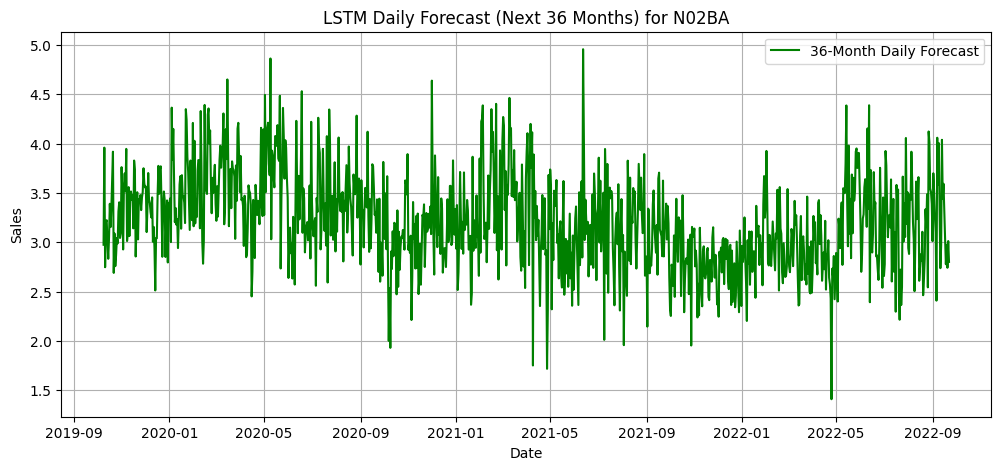

Epoch 1, R03_h1, Validation Loss: 0.0256
Epoch 2, R03_h1, Validation Loss: 0.0263
Epoch 3, R03_h1, Validation Loss: 0.0257
Epoch 4, R03_h1, Validation Loss: 0.0250
Epoch 5, R03_h1, Validation Loss: 0.0247
Epoch 6, R03_h1, Validation Loss: 0.0245
Epoch 7, R03_h1, Validation Loss: 0.0244
Epoch 8, R03_h1, Validation Loss: 0.0243
Epoch 9, R03_h1, Validation Loss: 0.0243
Epoch 10, R03_h1, Validation Loss: 0.0242
Epoch 1, R03_h2, Validation Loss: 0.0256
Epoch 2, R03_h2, Validation Loss: 0.0250
Epoch 3, R03_h2, Validation Loss: 0.0254
Epoch 4, R03_h2, Validation Loss: 0.0248
Epoch 5, R03_h2, Validation Loss: 0.0245
Epoch 6, R03_h2, Validation Loss: 0.0244
Epoch 7, R03_h2, Validation Loss: 0.0243
Epoch 8, R03_h2, Validation Loss: 0.0243
Epoch 9, R03_h2, Validation Loss: 0.0243
Epoch 10, R03_h2, Validation Loss: 0.0243
Epoch 1, R03_h3, Validation Loss: 0.0246
Epoch 2, R03_h3, Validation Loss: 0.0257
Epoch 3, R03_h3, Validation Loss: 0.0247
Epoch 4, R03_h3, Validation Loss: 0.0248
Epoch 5, R03_h

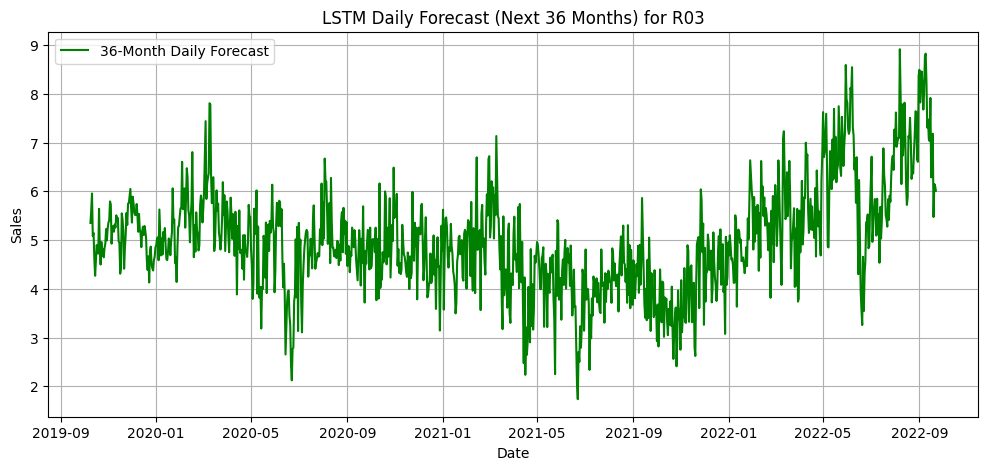

Epoch 1, R06_h1, Validation Loss: 0.0360
Epoch 2, R06_h1, Validation Loss: 0.0341
Epoch 3, R06_h1, Validation Loss: 0.0331
Epoch 4, R06_h1, Validation Loss: 0.0303
Epoch 5, R06_h1, Validation Loss: 0.0285
Epoch 6, R06_h1, Validation Loss: 0.0269
Epoch 7, R06_h1, Validation Loss: 0.0259
Epoch 8, R06_h1, Validation Loss: 0.0254
Epoch 9, R06_h1, Validation Loss: 0.0250
Epoch 10, R06_h1, Validation Loss: 0.0248
Epoch 1, R06_h2, Validation Loss: 0.0332
Epoch 2, R06_h2, Validation Loss: 0.0321
Epoch 3, R06_h2, Validation Loss: 0.0298
Epoch 4, R06_h2, Validation Loss: 0.0276
Epoch 5, R06_h2, Validation Loss: 0.0257
Epoch 6, R06_h2, Validation Loss: 0.0245
Epoch 7, R06_h2, Validation Loss: 0.0241
Epoch 8, R06_h2, Validation Loss: 0.0240
Epoch 9, R06_h2, Validation Loss: 0.0239
Epoch 10, R06_h2, Validation Loss: 0.0239
Epoch 1, R06_h3, Validation Loss: 0.0448
Epoch 2, R06_h3, Validation Loss: 0.0369
Epoch 3, R06_h3, Validation Loss: 0.0358
Epoch 4, R06_h3, Validation Loss: 0.0323
Epoch 5, R06_h

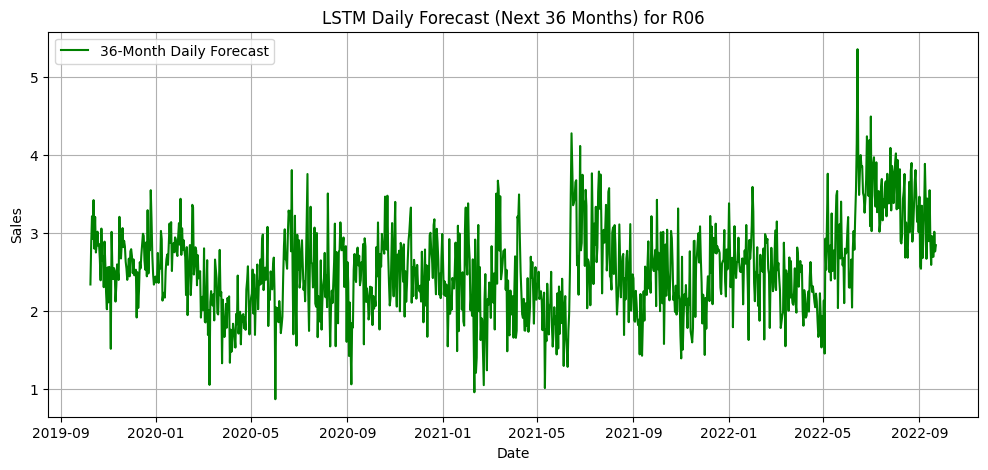

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
BATCH_SIZE = 64
FORECAST_HORIZON = 36 * 30  # 1080 days

# Assume df_salesdaily_LSTM is pre-loaded DataFrame
df = df_salesdaily_LSTM.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Add time-based features
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Drugs to forecast
best_model_summary = pd.read_csv("best_model_summary_metrics.csv")
forecast_drugs = best_model_summary[best_model_summary['Model'] == 'LSTM']['DrugCode'].tolist()

# Explicitly define input features
input_features = [
    'M01AB_t-1', 'M01AB_t-2', 'M01AB_t-3',
    'M01AE_t-1', 'M01AE_t-2', 'M01AE_t-3',
    'N02BA_t-1', 'N02BA_t-2', 'N02BA_t-3',
    'N02BE_t-1', 'N02BE_t-2', 'N02BE_t-3',
    'N05B_t-1', 'N05B_t-2', 'N05B_t-3',
    'N05C_t-1', 'N05C_t-2', 'N05C_t-3',
    'R03_t-1', 'R03_t-2', 'R03_t-3',
    'R06_t-1', 'R06_t-2', 'R06_t-3','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
    'month', 'quarter', 'year', 'month_cos', 'month_sin'
]

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Training function
def train_model(model, train_loader, val_loader, learning_rate, epochs, drug, horizon):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            val_loss = sum(loss_fn(model(x), y).item() for x, y in val_loader) / len(val_loader)
        print(f"Epoch {epoch+1}, {drug}_h{horizon}, Validation Loss: {val_loss:.4f}")
    return model

# Forecasting correctly
results = []
dates_future = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods=FORECAST_HORIZON, freq='D')
future_df = pd.DataFrame(index=dates_future)

for drug in forecast_drugs:
    params = optimal_lstm_parameters.get(drug, {})
    seq_length = params.get('seq_length', 30)
    hidden_size = params.get('hidden_size', 64)
    learning_rate = params.get('learning_rate', 0.001)
    epochs = params.get('epochs', 10)

    data = df[input_features + [drug]].dropna()
    features = data[input_features]
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_scaled = scaler_X.fit_transform(features)

    for h in range(1, FORECAST_HORIZON + 1):
        y_shifted = data[[drug]].shift(-h).dropna()
        min_len = min(len(X_scaled), len(y_shifted))
        X_h = torch.tensor(X_scaled[:min_len - seq_length], dtype=torch.float32)
        y_h = torch.tensor(scaler_y.fit_transform(y_shifted[:min_len - seq_length]), dtype=torch.float32)

        X_seq, y_seq = [], []
        for i in range(len(X_h) - seq_length):
            X_seq.append(X_h[i:i + seq_length])
            y_seq.append(y_h[i + seq_length])

        if len(X_seq) < 10:
            continue

        X_seq = torch.stack(X_seq)
        y_seq = torch.stack(y_seq)

        train_end, val_end = int(0.7 * len(X_seq)), int(0.85 * len(X_seq))
        X_train, y_train = X_seq[:train_end], y_seq[:train_end]
        X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]

        train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
        val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

        model = LSTMModel(input_size=X_scaled.shape[1], hidden_size=hidden_size)
        model = train_model(model, train_loader, val_loader, learning_rate, epochs, drug, h)

        model.eval()
        with torch.no_grad():
            last_seq = X_seq[-1].unsqueeze(0)
            pred = model(last_seq).item()
            future_df.loc[dates_future[h-1], drug] = scaler_y.inverse_transform([[pred]])[0][0]

    plt.figure(figsize=(12, 5))
    plt.plot(future_df[drug], label='36-Month Daily Forecast', color='green')
    plt.title(f"LSTM Daily Forecast (Next 36 Months) for {drug}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

future_df.to_csv("lstm_forecast_daily_36_months.csv")



🔁 Running forecast for M01AE using optimal parameters
M01AE - RMSE: 2.27, R^2 Score: 0.0679, MAE: 1.73
⏳ Forecasting: M01AE - Day 1/1080
⏳ Forecasting: M01AE - Day 2/1080
⏳ Forecasting: M01AE - Day 3/1080
⏳ Forecasting: M01AE - Day 4/1080
⏳ Forecasting: M01AE - Day 5/1080
⏳ Forecasting: M01AE - Day 6/1080
⏳ Forecasting: M01AE - Day 7/1080
⏳ Forecasting: M01AE - Day 8/1080
⏳ Forecasting: M01AE - Day 9/1080
⏳ Forecasting: M01AE - Day 10/1080
⏳ Forecasting: M01AE - Day 11/1080
⏳ Forecasting: M01AE - Day 12/1080
⏳ Forecasting: M01AE - Day 13/1080
⏳ Forecasting: M01AE - Day 14/1080
⏳ Forecasting: M01AE - Day 15/1080
⏳ Forecasting: M01AE - Day 16/1080
⏳ Forecasting: M01AE - Day 17/1080
⏳ Forecasting: M01AE - Day 18/1080
⏳ Forecasting: M01AE - Day 19/1080
⏳ Forecasting: M01AE - Day 20/1080
⏳ Forecasting: M01AE - Day 21/1080
⏳ Forecasting: M01AE - Day 22/1080
⏳ Forecasting: M01AE - Day 23/1080
⏳ Forecasting: M01AE - Day 24/1080
⏳ Forecasting: M01AE - Day 25/1080
⏳ Forecasting: M01AE - Day 26/

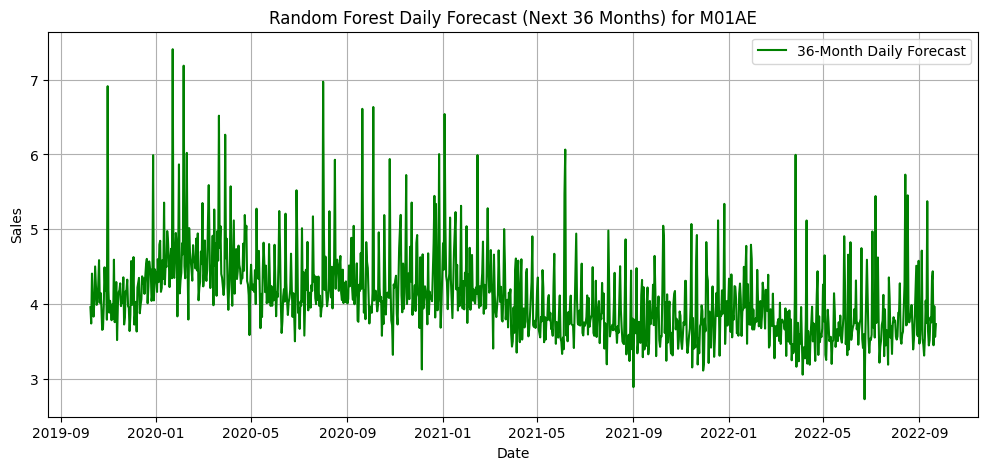


🔁 Running forecast for N02BE using optimal parameters
N02BE - RMSE: 13.50, R^2 Score: 0.3450, MAE: 9.62
⏳ Forecasting: N02BE - Day 1/1080
⏳ Forecasting: N02BE - Day 2/1080
⏳ Forecasting: N02BE - Day 3/1080
⏳ Forecasting: N02BE - Day 4/1080
⏳ Forecasting: N02BE - Day 5/1080
⏳ Forecasting: N02BE - Day 6/1080
⏳ Forecasting: N02BE - Day 7/1080
⏳ Forecasting: N02BE - Day 8/1080
⏳ Forecasting: N02BE - Day 9/1080
⏳ Forecasting: N02BE - Day 10/1080
⏳ Forecasting: N02BE - Day 11/1080
⏳ Forecasting: N02BE - Day 12/1080
⏳ Forecasting: N02BE - Day 13/1080
⏳ Forecasting: N02BE - Day 14/1080
⏳ Forecasting: N02BE - Day 15/1080
⏳ Forecasting: N02BE - Day 16/1080
⏳ Forecasting: N02BE - Day 17/1080
⏳ Forecasting: N02BE - Day 18/1080
⏳ Forecasting: N02BE - Day 19/1080
⏳ Forecasting: N02BE - Day 20/1080
⏳ Forecasting: N02BE - Day 21/1080
⏳ Forecasting: N02BE - Day 22/1080
⏳ Forecasting: N02BE - Day 23/1080
⏳ Forecasting: N02BE - Day 24/1080
⏳ Forecasting: N02BE - Day 25/1080
⏳ Forecasting: N02BE - Day 26

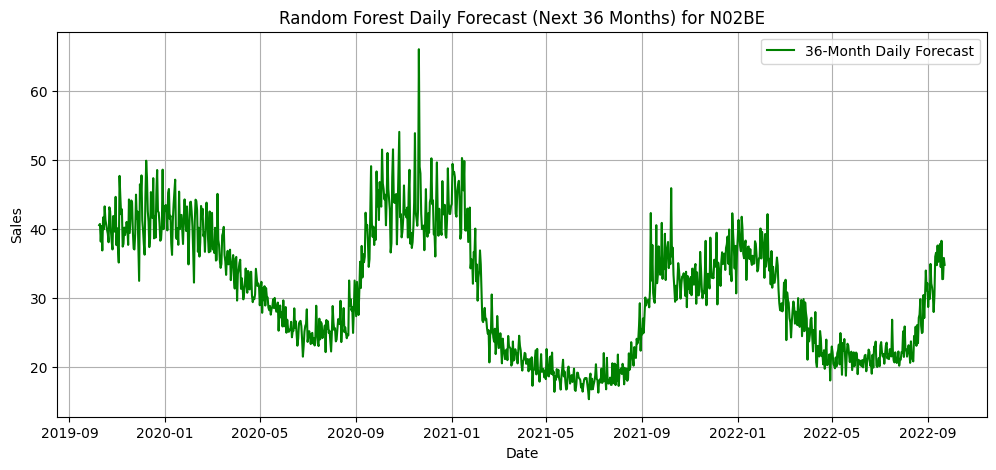

✔️ Random Forest 36-month forecast saved to CSV.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

df = df_salesdaily_LSTM.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Add time-based features
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Define target drug columns and feature columns
best_model_summary = pd.read_csv("best_model_summary_metrics.csv")
drug_columns = best_model_summary[best_model_summary['Model'] == 'Random Forest']['DrugCode'].tolist()
input_features = [
    'M01AB_t-1', 'M01AB_t-2', 'M01AB_t-3',
    'M01AE_t-1', 'M01AE_t-2', 'M01AE_t-3',
    'N02BA_t-1', 'N02BA_t-2', 'N02BA_t-3',
    'N02BE_t-1', 'N02BE_t-2', 'N02BE_t-3',
    'N05B_t-1', 'N05B_t-2', 'N05B_t-3',
    'N05C_t-1', 'N05C_t-2', 'N05C_t-3',
    'R03_t-1', 'R03_t-2', 'R03_t-3',
    'R06_t-1', 'R06_t-2', 'R06_t-3','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'month', 'quarter', 'year', 'month_cos', 'month_sin'
]

# Create future dataframe with next 36 * 30 days (approx 3 years)
dates_future = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods=36 * 30, freq='D')
future_df = pd.DataFrame(index=dates_future)

# Store evaluation metrics
results = []

# Forecast loop for each drug
for drug in drug_columns:
    print(f"\n🔁 Running forecast for {drug} using optimal parameters")
    param_grid = optimal_random_forest_parameters.get(drug, {})
    data = df[input_features + [drug]].dropna()
    target = data[[drug]]
    features = data[input_features]

    # Scale features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(target)

    # Train/validation/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    # Train model directly using optimal parameters
    rf_best = RandomForestRegressor(**param_grid)
    rf_best.fit(X_train, y_train.ravel())

    # Predict on test set
    y_pred = rf_best.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inv = scaler_y.inverse_transform(y_test)

    # Evaluation
    rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
    r2 = r2_score(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    print(f"{drug} - RMSE: {rmse:.2f}, R^2 Score: {r2:.4f}, MAE: {mae:.2f}")

    results.append({"Drug": drug, "RMSE": rmse, "R^2": r2, "MAE": mae})

    # Direct Multi-Step Forecasting
    forecast_scaled = []

    # Create shifted targets for all horizons first
    shifted_targets = {
        f'{drug}_h{h}': data[drug].shift(-h)
        for h in range(1, 36 * 30 + 1)
    }
    shifted_df = pd.DataFrame(shifted_targets)
    data = pd.concat([data, shifted_df], axis=1)

    horizon_data = data.dropna()

    for h in range(1, 36 * 30 + 1):
        #print(f"⏳ Forecasting: {drug} - Day {h}/1080")
        y_h = horizon_data[f'{drug}_h{h}']
        X_h = horizon_data[input_features]

        X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.3, shuffle=False)

        model_h = RandomForestRegressor(**optimal_random_forest_parameters[drug])
        model_h.fit(X_train_h, y_train_h)

        # Forecast one-step-ahead using last known feature row
        last_known_input = df[input_features].iloc[-1:]
        forecast_h = model_h.predict(last_known_input)[0]
        forecast_h = max(forecast_h, 0)  # avoid negative predictions
        forecast_h_scaled = scaler_y.transform([[forecast_h]])[0][0]
        forecast_scaled.append(forecast_h_scaled)

    forecast_scaled = np.array(forecast_scaled).reshape(-1, 1)
    forecast_unscaled = scaler_y.inverse_transform(forecast_scaled)
    future_df[drug] = forecast_unscaled.flatten()

    # Plot future forecast
    plt.figure(figsize=(12, 5))
    plt.plot(future_df[drug], label='36-Month Daily Forecast', color='green')
    plt.title(f"Random Forest Daily Forecast (Next 36 Months) for {drug}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

# Save to CSV
future_df.to_csv("random_forest_forecast_daily_36_months.csv")
print("✔️ Random Forest 36-month forecast saved to CSV.")



🔁 Running forecast for M01AB using optimal parameters
M01AB - RMSE: 2.89, R^2 Score: 0.0043, MAE: 2.25
⏳ Forecasting: M01AB - Day 1/1080
⏳ Forecasting: M01AB - Day 2/1080
⏳ Forecasting: M01AB - Day 3/1080
⏳ Forecasting: M01AB - Day 4/1080
⏳ Forecasting: M01AB - Day 5/1080
⏳ Forecasting: M01AB - Day 6/1080
⏳ Forecasting: M01AB - Day 7/1080
⏳ Forecasting: M01AB - Day 8/1080
⏳ Forecasting: M01AB - Day 9/1080
⏳ Forecasting: M01AB - Day 10/1080
⏳ Forecasting: M01AB - Day 11/1080
⏳ Forecasting: M01AB - Day 12/1080
⏳ Forecasting: M01AB - Day 13/1080
⏳ Forecasting: M01AB - Day 14/1080
⏳ Forecasting: M01AB - Day 15/1080
⏳ Forecasting: M01AB - Day 16/1080
⏳ Forecasting: M01AB - Day 17/1080
⏳ Forecasting: M01AB - Day 18/1080
⏳ Forecasting: M01AB - Day 19/1080
⏳ Forecasting: M01AB - Day 20/1080
⏳ Forecasting: M01AB - Day 21/1080
⏳ Forecasting: M01AB - Day 22/1080
⏳ Forecasting: M01AB - Day 23/1080
⏳ Forecasting: M01AB - Day 24/1080
⏳ Forecasting: M01AB - Day 25/1080
⏳ Forecasting: M01AB - Day 26/

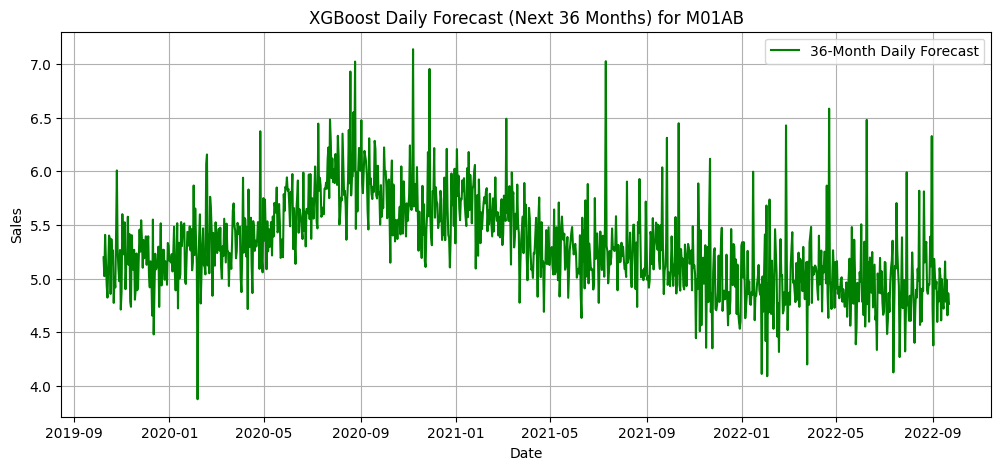

✔️ XGBoost 36-month forecast saved to CSV.


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df = df_salesdaily_LSTM.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Add time-based features
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Define target drug columns and feature columns
best_model_summary = pd.read_csv("best_model_summary_metrics.csv")
drug_columns = best_model_summary[best_model_summary['Model'] == 'XGBoost']['DrugCode'].tolist()
input_features = [
    'M01AB_t-1', 'M01AB_t-2', 'M01AB_t-3',
    'M01AE_t-1', 'M01AE_t-2', 'M01AE_t-3',
    'N02BA_t-1', 'N02BA_t-2', 'N02BA_t-3',
    'N02BE_t-1', 'N02BE_t-2', 'N02BE_t-3',
    'N05B_t-1', 'N05B_t-2', 'N05B_t-3',
    'N05C_t-1', 'N05C_t-2', 'N05C_t-3',
    'R03_t-1', 'R03_t-2', 'R03_t-3',
    'R06_t-1', 'R06_t-2', 'R06_t-3','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'month', 'quarter', 'year', 'month_cos', 'month_sin'
]

# Create future dataframe with next 36 * 30 days (approx 3 years)
dates_future = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods=36 * 30, freq='D')
future_df = pd.DataFrame(index=dates_future)

# Store evaluation metrics
results = []

# Forecast loop for each drug
for drug in drug_columns:
    print(f"\n🔁 Running forecast for {drug} using optimal parameters")
    param_grid = optimal_xgboost_parameters.get(drug, {})
    data = df[input_features + [drug]].dropna()
    target = data[[drug]]
    features = data[input_features]

    # Scale features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(target)

    # Train/validation/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    # Train model directly using optimal parameters
    xgb_best = XGBRegressor(**param_grid)
    xgb_best.fit(X_train, y_train.ravel())

    # Predict on test set
    y_pred = xgb_best.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inv = scaler_y.inverse_transform(y_test)

    # Evaluation
    rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
    r2 = r2_score(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    print(f"{drug} - RMSE: {rmse:.2f}, R^2 Score: {r2:.4f}, MAE: {mae:.2f}")

    results.append({"Drug": drug, "RMSE": rmse, "R^2": r2, "MAE": mae})

    # Direct Multi-Step Forecasting
    forecast_scaled = []

    # Create shifted targets for all horizons first
    shifted_targets = {
        f'{drug}_h{h}': data[drug].shift(-h)
        for h in range(1, 36 * 30 + 1)
    }
    shifted_df = pd.DataFrame(shifted_targets)
    data = pd.concat([data, shifted_df], axis=1)

    horizon_data = data.dropna()

    for h in range(1, 36 * 30 + 1):
        print(f"⏳ Forecasting: {drug} - Day {h}/1080")
        y_h = horizon_data[f'{drug}_h{h}']
        X_h = horizon_data[input_features]

        X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.3, shuffle=False)

        model_h = XGBRegressor(**optimal_xgboost_parameters[drug])
        model_h.fit(X_train_h, y_train_h)

        # Forecast one-step-ahead using last known feature row
        last_known_input = df[input_features].iloc[-1:]
        forecast_h = model_h.predict(last_known_input)[0]
        forecast_h = max(forecast_h, 0)  # avoid negative predictions
        forecast_h_scaled = scaler_y.transform([[forecast_h]])[0][0]
        forecast_scaled.append(forecast_h_scaled)

    forecast_scaled = np.array(forecast_scaled).reshape(-1, 1)
    forecast_unscaled = scaler_y.inverse_transform(forecast_scaled)
    future_df[drug] = forecast_unscaled.flatten()

    # Plot future forecast
    plt.figure(figsize=(12, 5))
    plt.plot(future_df[drug], label='36-Month Daily Forecast', color='green')
    plt.title(f"XGBoost Daily Forecast (Next 36 Months) for {drug}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

# Save to CSV
future_df.to_csv("xgboost_forecast_daily_36_months.csv")
print("✔️ XGBoost 36-month forecast saved to CSV.")


In [100]:
import pandas as pd

# Load all 3 forecast CSVs
bes_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\best_model_summary_metrics.csv", index_col=0, parse_dates=True)
bes_df.fillna('N/A', inplace=True)

lstm_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\lstm_forecast_daily_36_months.csv", index_col=0, parse_dates=True)
rf_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\random_forest_forecast_daily_36_months.csv", index_col=0, parse_dates=True)
xgb_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\xgboost_forecast_daily_36_months.csv", index_col=0, parse_dates=True)
prof_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\prophet_forecast.csv", index_col=0, parse_dates=True)
seas_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\seasonality_strength.csv", index_col=0, parse_dates=True)

# Create a new Excel writer using openpyxl engine
output_path = r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\Forecasting Data.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    bes_df.to_excel(writer, sheet_name='Best Model Summary Metrics')
    prof_df.to_excel(writer, sheet_name='Prophet Forecast')
    seas_df.to_excel(writer, sheet_name='Seasonality Strength')
    lstm_df.to_excel(writer, sheet_name='LSTM Forecast')
    rf_df.to_excel(writer, sheet_name='Random Forest Forecast')
    xgb_df.to_excel(writer, sheet_name='XGBoost Forecast')
    

output_path


FileNotFoundError: [Errno 2] No such file or directory: "C:\\Users\\Rahul's PC\\Desktop\\MYDOCS\\Projects\\Portfolio-Projects\\Pharma_Sales_Analysis\\best_model_summary_metrics.csv"

In [ ]:
bes_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\best_model_summary_metrics.csv", index_col=0, parse_dates=True)
bes_df.fillna('N/A', inplace=True)

lstm_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\lstm_forecast_daily_36_months.csv", index_col=0, parse_dates=True)
rf_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\random_forest_forecast_daily_36_months.csv", index_col=0, parse_dates=True)
xgb_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\xgboost_forecast_daily_36_months.csv", index_col=0, parse_dates=True)
prof_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\prophet_forecast.csv", index_col=0, parse_dates=True)
seas_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\seasonality_strength.csv", index_col=0, parse_dates=True)

# Create a new Excel writer using openpyxl engine
output_path = r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\Forecasting Data.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    bes_df.to_excel(writer, sheet_name='Best Model Summary Metrics')
    prof_df.to_excel(writer, sheet_name='Prophet Forecast')
    seas_df.to_excel(writer, sheet_name='Seasonality Strength')
    lstm_df.to_excel(writer, sheet_name='LSTM Forecast')
    rf_df.to_excel(writer, sheet_name='Random Forest Forecast')
    xgb_df.to_excel(writer, sheet_name='XGBoost Forecast')
    

output_path

C:\Users\Rahul's PC\AppData\Local\Temp\ipykernel_22712\1823964529.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bes_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\best_model_summary_metrics.csv", index_col=0, parse_dates=True)
C:\Users\Rahul's PC\AppData\Local\Temp\ipykernel_22712\1823964529.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seas_df = pd.read_csv(r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts\seasonality_strength.csv", index_col=0, parse_dates=True)


In [99]:
import shutil
import os

# Define target directory
target_dir = r"C:\Users\Rahul's PC\Desktop\MYDOCS\Projects\Portfolio-Projects\Pharma_Sales_Analysis\Forecasts"

# List of files to move
files_to_move = [
    "best_model_summary_metrics.csv",
    "lstm_forecast_daily_36_months.csv",
    "random_forest_forecast_daily_36_months.csv",
    "prophet_forecast.csv",
    "xgboost_forecast_daily_36_months.csv",
    "seasonality_strength.csv"
]

# Move each file to the Forecasts folder
for filename in files_to_move:
    source_path = os.path.join(os.getcwd(), filename)
    target_path = os.path.join(target_dir, filename)
    if os.path.exists(source_path):
        shutil.move(source_path, target_path)
        print(f"✅ Moved: {filename}")
    else:
        print(f"⚠️ File not found: {filename}")


✅ Moved: best_model_summary_metrics.csv
✅ Moved: lstm_forecast_daily_36_months.csv
✅ Moved: random_forest_forecast_daily_36_months.csv
✅ Moved: prophet_forecast.csv
✅ Moved: xgboost_forecast_daily_36_months.csv
✅ Moved: seasonality_strength.csv
